# <center>Data 1030 - Final Project</center>

### Data 1030 Environment

In [1]:
from __future__ import print_function
from distutils.version import LooseVersion as Version
import sys

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.9 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == min_ver:
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(sys.version)
if pyversion >= "3.9":
    print(OK, "Python version is %s" % sys.version)
elif pyversion < "3.9":
    print(FAIL, "Python version 3.9 is required,"
                " but %s is installed." % sys.version)
else:
    print(FAIL, "Unknown Python version: %s" % sys.version)

    
print()
requirements = {'numpy': "1.21.1", 'matplotlib': "3.4.2",'sklearn': "0.24.2", 
                'pandas': "1.3.1",'xgboost': "1.3.3", 'shap': "0.39.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.9.7 | packaged by conda-forge | (default, Sep  2 2021, 17:58:46) 
[Clang 11.1.0 ]

[ OK ] numpy version 1.21.1 is installed.
[ OK ] matplotlib version 3.4.2 is installed.
[ OK ] sklearn version 0.24.2 is installed.
[ OK ] pandas version 1.3.1 is installed.
[ OK ] xgboost version 1.3.3 is installed.
[ OK ] shap version 0.39.0 is installed.


### Evaluation

Compare the XGBoost models with the baseline.

In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

file = open('../results/xgb_models.save', 'rb')
xgb_models = pickle.load(file)
file.close()

file = open('../data/data_preprocessed.save', 'rb')
other_sets, test_sets = pickle.load(file)
file.close()

In [3]:
y_tests = []
y_tests_pred = []
y_baselines_pred = []


for i in range(len(test_sets)):
    X_test, y_test = test_sets[i]
    X_train, y_train = other_sets[i]
    xgb_model = xgb_models[i][1]
    xgb_model.fit(X_train, y_train)
    y_test_pred = xgb_model.predict(X_test)
    y_baseline_pred = np.repeat(max(set(y_train), key = list(y_train).count), len(y_test))
    
    y_tests.append(y_test)
    y_tests_pred.append(y_test_pred)
    y_baselines_pred.append(y_baseline_pred)

In [4]:
baseline_acc = [accuracy_score(y_tests[i], y_baselines_pred[i]) for i in range(len(y_baselines_pred))]
accuracy_scores = [accuracy_score(y_tests[i], y_tests_pred[i]) for i in range(len(y_tests))]

print('baseline accuracy score:', np.mean(baseline_acc), '+/-', np.std(baseline_acc))
print('xgboost accuracy score:', np.mean(accuracy_scores), '+/-', np.std(accuracy_scores))

baseline accuracy score: 0.7422448979591836 +/- 0.01581599736326332
xgboost accuracy score: 0.8462244897959182 +/- 0.009809195933645088


We collect all the predictions for the 10 XGBoost models to get the confusion matrix.

In [5]:
y_tests_comb = []
y_tests_pred_comb = []
for i in range(len(y_tests)):
    y_tests_comb.extend(y_tests[i])
    y_tests_pred_comb.extend(y_tests_pred[i])

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = np.array(classes)
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

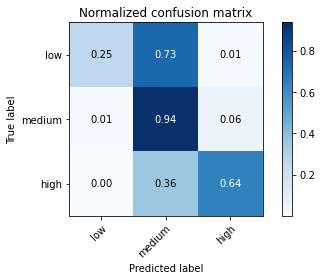

In [7]:
# Use combined y_test_pred
plot_confusion_matrix(y_tests_comb, y_tests_pred_comb, classes = ['low', 'medium', 'high'], normalize=True)
plt.savefig('../figures/confusion_matrix_combined.jpg', dpi=300)
plt.show()

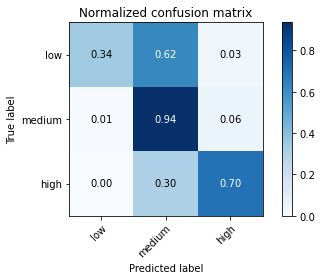

In [8]:
# Choose the best performance model (the last one) to do the confusion matrix
plot_confusion_matrix(y_tests[-1], y_tests_pred[-1], classes = ['low', 'medium', 'high'], normalize=True)
plt.savefig('../figures/confusion_matrix_best.jpg', dpi=300)
plt.show()

In [9]:
xgb_models[-1]

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('std', StandardScaler(),
                                                  ['fixed acidity',
                                                   'volatile acidity',
                                                   'citric acid',
                                                   'residual sugar',
                                                   'chlorides',
                                                   'free sulfur dioxide',
                                                   'total sulfur dioxide',
                                                   'density', 'pH', 'sulphates',
                                                   'alcohol'])])),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode...
                               learning_rate=0.300000012, max_delta_step=0,
     